# Step 1

We download ETF prices for the following exchange-traded funds: SPY (S&P 500 ETF), TLT (20+ Year Treasury Bond ETF), SHY (1-3 Year Treasury Bond ETF), GLD (Gold ETF), and DBO (Crude Oil ETF). We get the closing prices, adjusted for splits and dividends, for the time frame from January 1, 2008, to December 31, 2022.  We will use the data from January 1, 2018 - December 31, 2022 as test data and the rest as training and validation data.  We will use the last 20% of the training data as validation data when training the neural network models.

In [10]:
import yfinance as yf

# Define symbols for different assets
symbols = ["SPY", "TLT", "SHY", "GLD", "DBO"]

# Download data for each symbol
data = yf.download(symbols, start="2008-01-01", end="2022-12-31")

# Print the downloaded data for the "Close" prices
data = data["Adj Close"]

[*********************100%%**********************]  5 of 5 completed


In [11]:
from datetime import datetime

train_start_date = datetime(2008,1,1)
train_end_date = datetime(2018,1,1)

train_data = data.loc[train_start_date:train_end_date]
test_data = data.loc[datetime(2018,1,1):]

Here is a plot of the prices of the five different exchange-traded funds.

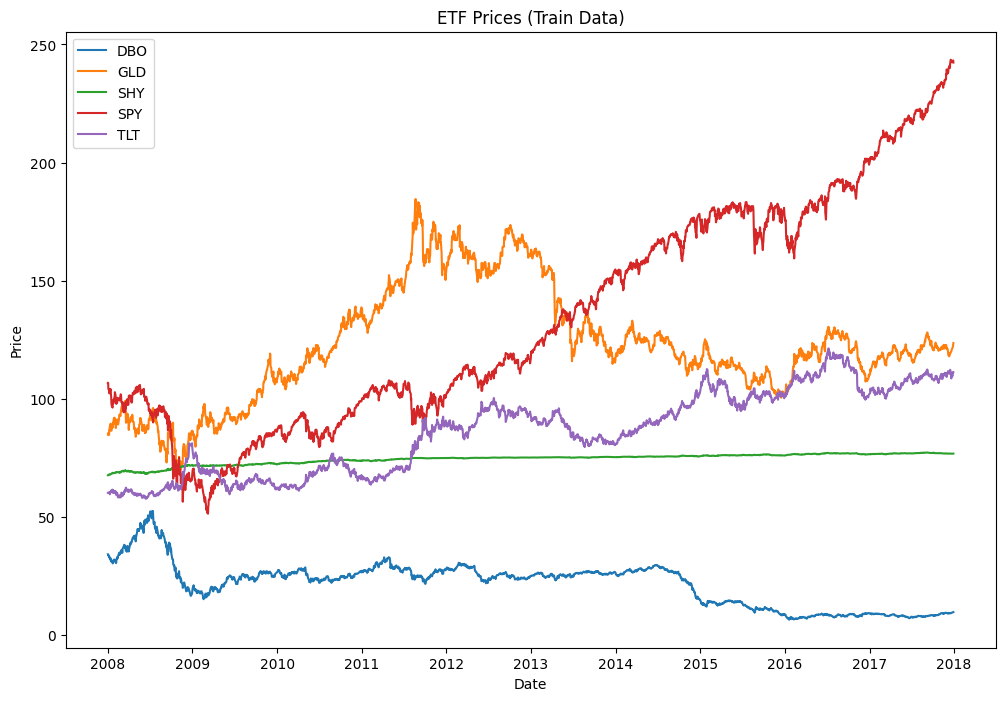

In [12]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Plotting individual ETF prices
plt.figure(figsize=(12, 8))
for symbol in train_data.columns:
    plt.plot(train_data[symbol], label=symbol)

plt.title('ETF Prices (Train Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Here is a histogram of the returns for the traded funds.  We can see that they appear to have a symmetrical distribution, but may have kurtosis relative to the normal distribution.

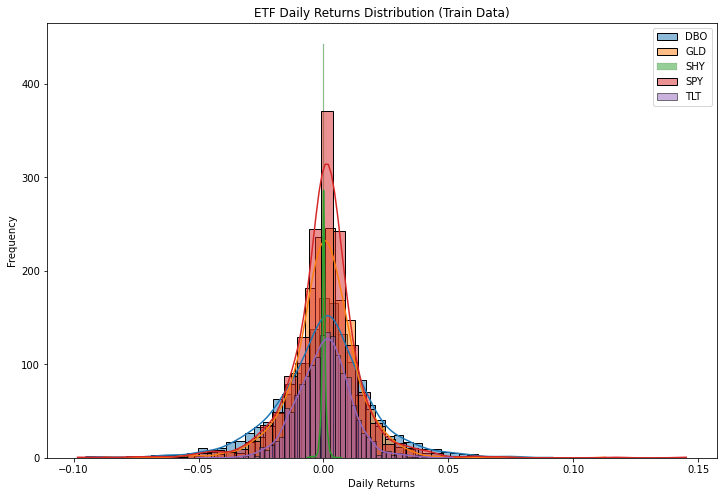

In [ ]:
# Daily returns calculation
daily_returns = train_data.pct_change().dropna()

# Plotting individual ETF daily returns distribution
plt.figure(figsize=(12, 8))
for symbol in daily_returns.columns:
    sns.histplot(daily_returns[symbol], bins=50, kde=True, label=symbol)

plt.title('ETF Daily Returns Distribution (Train Data)')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Here is a plot of the joint distributions of the five exchange traded funds, together with a heat map showing the correlation coefficients.

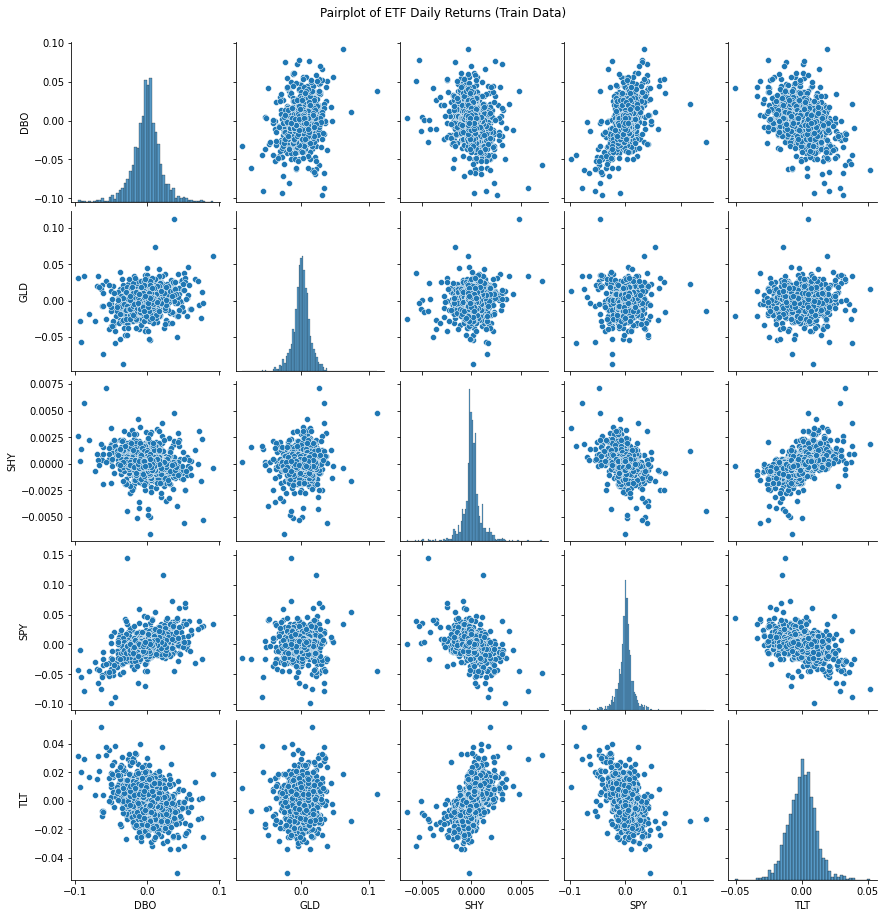

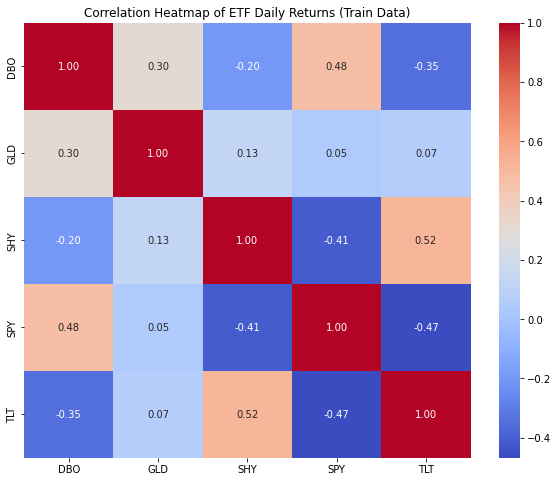

In [ ]:

# Pairplot to visualize joint distributions and correlations
sns.pairplot(daily_returns, kind='scatter')
plt.suptitle('Pairplot of ETF Daily Returns (Train Data)', y=1.02)
plt.show()

# Correlation heatmap
corr_matrix = daily_returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of ETF Daily Returns (Train Data)')
plt.show()

DBO (crude oil) has a moderate positive correlation with SPY (S&P 500) and a negative correlation with TLT (20-year Treasury bonds).
GLD (gold) has a slight positive correlation with DBO and an even smaller positive correlation with SHY (1-3 year Treasury bonds).
SHY and TLT have a strong positive correlation, which is interesting because they are both Treasury bonds but with different maturities.
SPY has a moderate positive correlation with DBO and a moderate negative correlation with TLT.


We plotted the time series for the price levels of each ETF, and additionally plotted pairplots as well as histograms of the daily returns for each ETF.

Summary Statistics of Daily Returns:
               DBO          GLD          SHY          SPY          TLT
count  1510.000000  1510.000000  1510.000000  1510.000000  1510.000000
mean      0.000032     0.000303     0.000072     0.000363     0.000248
std       0.019882     0.013824     0.000979     0.015344     0.010550
min      -0.095133    -0.087808    -0.006566    -0.098448    -0.050449
25%      -0.010020    -0.006123    -0.000354    -0.005177    -0.006364
50%       0.000760     0.000699     0.000006     0.000741     0.000527
75%       0.010343     0.007624     0.000474     0.006682     0.006719
max       0.091715     0.112905     0.007095     0.145197     0.051662


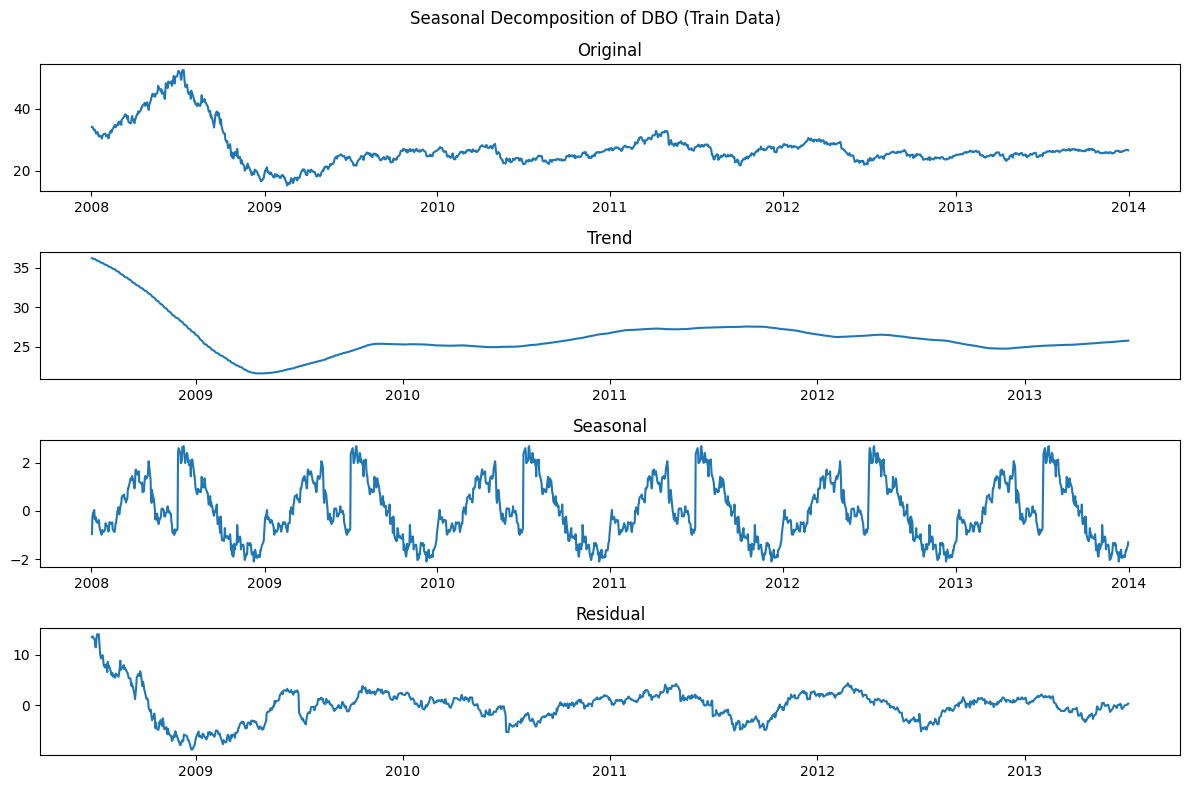

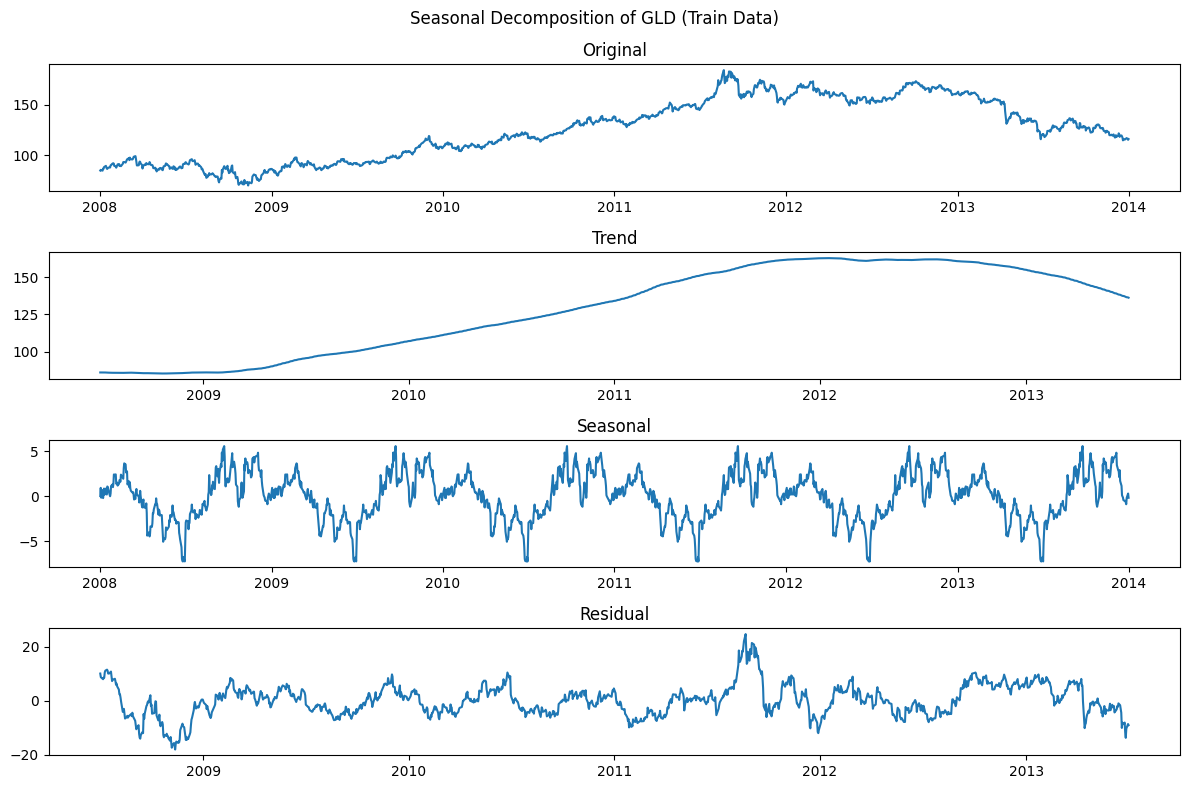

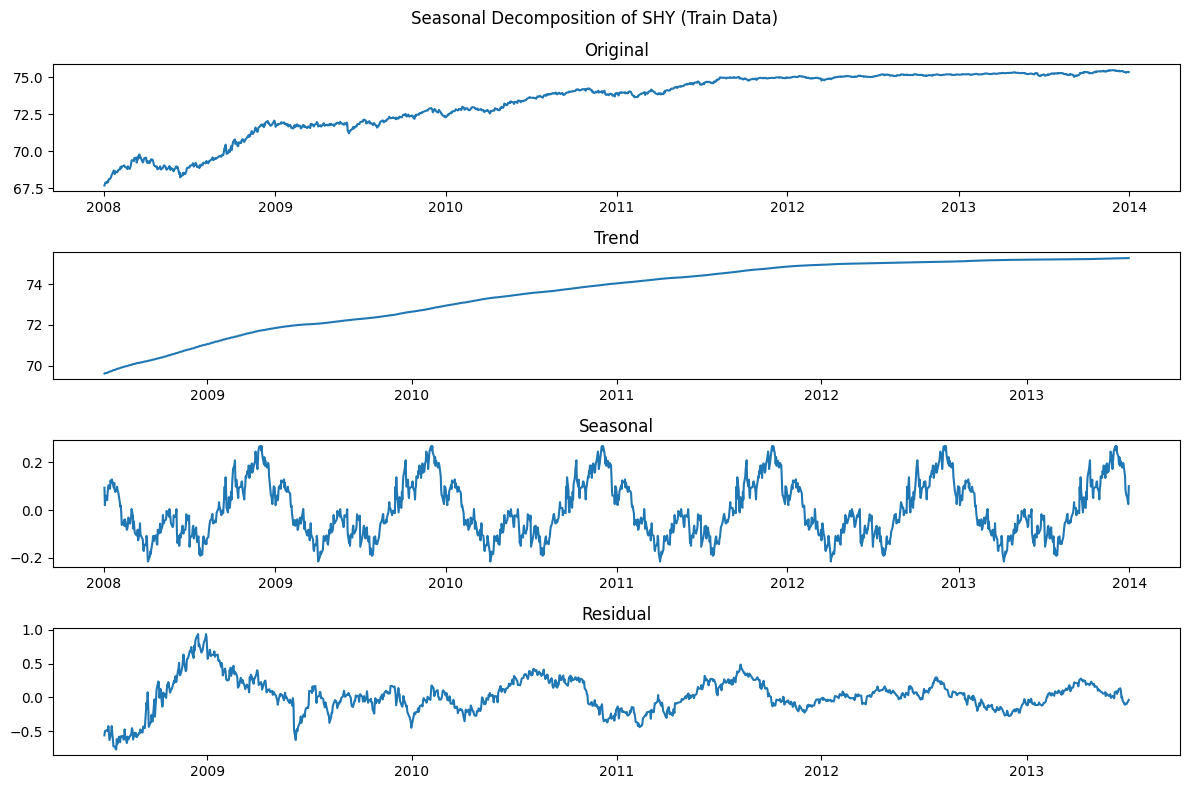

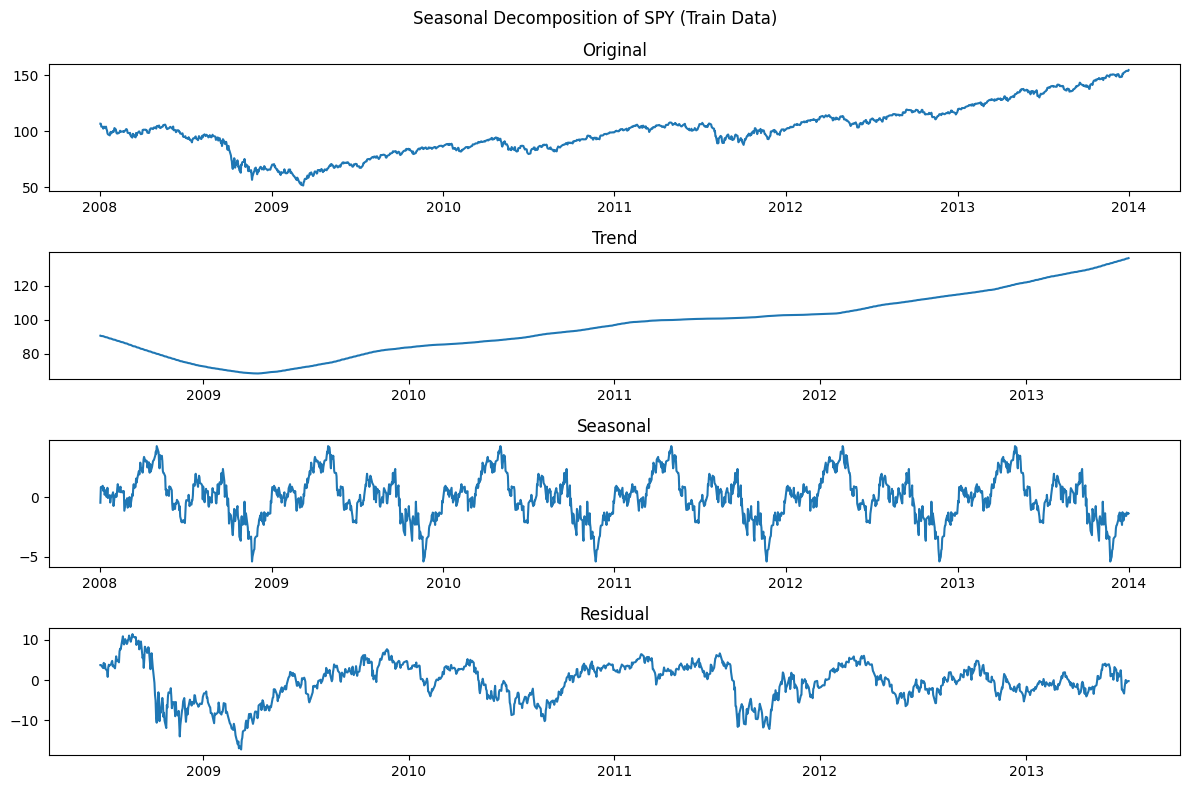

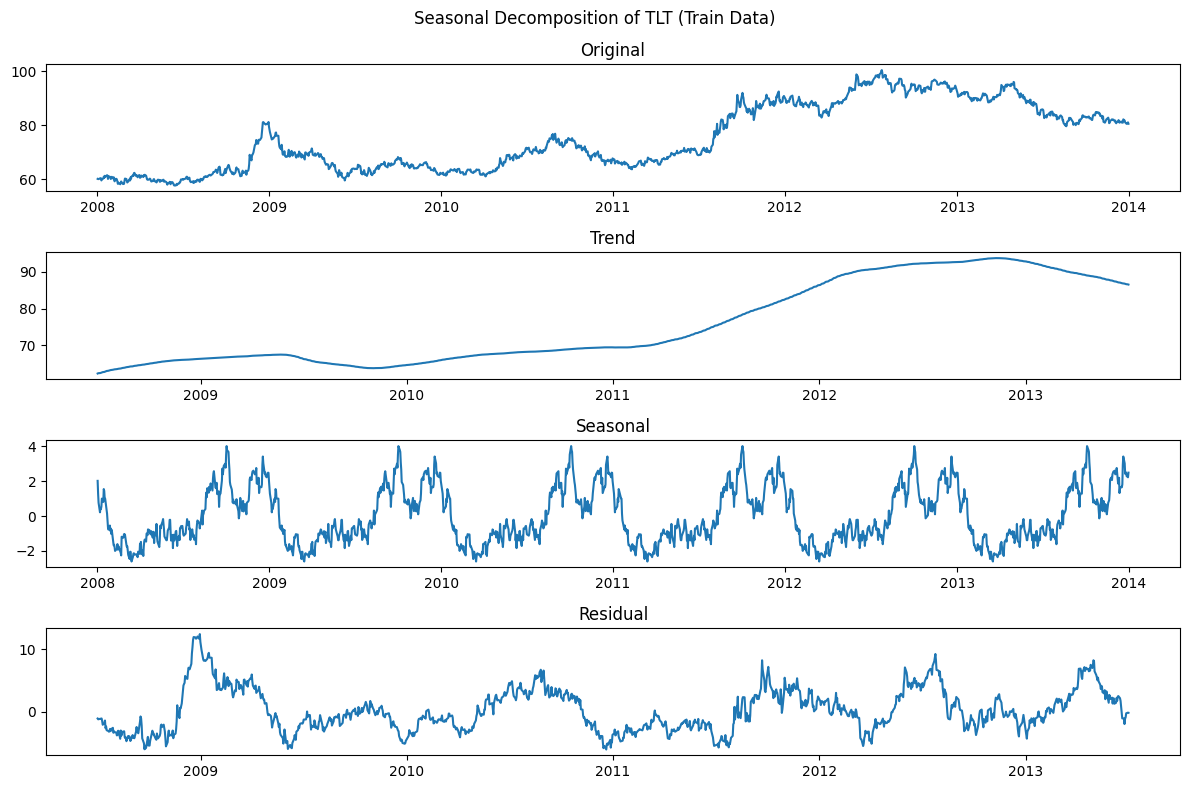

ADF Test for DBO:
ADF Statistic: -39.8829983163628
p-value: 0.0
Critical Values: {'1%': -3.434690926976026, '5%': -2.863457245470903, '10%': -2.5677907166982643}
Stationary? Yes
-------------------------
ADF Test for GLD:
ADF Statistic: -38.62240722772884
p-value: 0.0
Critical Values: {'1%': -3.434690926976026, '5%': -2.863457245470903, '10%': -2.5677907166982643}
Stationary? Yes
-------------------------
ADF Test for SHY:
ADF Statistic: -8.30165474626391
p-value: 4.003302600141192e-13
Critical Values: {'1%': -3.4347582315402434, '5%': -2.863486949792871, '10%': -2.567806534528638}
Stationary? Yes
-------------------------
ADF Test for SPY:
ADF Statistic: -8.953068189016816
p-value: 8.618799824198347e-15
Critical Values: {'1%': -3.4347493345634006, '5%': -2.863483023222698, '10%': -2.5678044435869762}
Stationary? Yes
-------------------------
ADF Test for TLT:
ADF Statistic: -40.467252800543086
p-value: 0.0
Critical Values: {'1%': -3.434690926976026, '5%': -2.863457245470903, '10%': -2

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Assuming you have already fetched and prepared the train_data DataFrame

# Summary statistics of daily returns
daily_returns_stats = daily_returns.describe()
print("Summary Statistics of Daily Returns:")
print(daily_returns_stats)

# Seasonality analysis using seasonal decomposition
for symbol in daily_returns.columns:
    decomposition = seasonal_decompose(train_data[symbol], model='additive', period=252)  # Assuming 252 trading days in a year
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    fig.suptitle(f'Seasonal Decomposition of {symbol} (Train Data)')
    axes[0].set_title('Original')
    axes[0].plot(train_data[symbol])
    axes[1].set_title('Trend')
    axes[1].plot(decomposition.trend)
    axes[2].set_title('Seasonal')
    axes[2].plot(decomposition.seasonal)
    axes[3].set_title('Residual')
    axes[3].plot(decomposition.resid)
    plt.tight_layout()
    plt.show()

# Stationarity test using Augmented Dickey-Fuller test
for symbol in daily_returns.columns:
    result = adfuller(daily_returns[symbol])
    print(f"ADF Test for {symbol}:")
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print("Stationary?" , "No" if result[1] > 0.05 else "Yes")
    print("-------------------------")

 The ADF statistics for daily returns were remarkably low, demonstrating strong evidence against the presence of a unit root (indicative of non-stationarity).

 This suggests that the daily returns for each ETF: crude oil (DBO), gold (GLD), short-term Treasuries (SHY), the S&P 500 index (SPY), or long-term Treasuries (TLT)—showed remarkably stationary behavior.

 The residual values appear to be high relative to the seasonal component, suggesting that decomposing into trend and seasonal components is not helpful.

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [27]:
spy_train, spy_test = train_data["SPY"],  test_data["SPY"]

We calculate rolling returns for the S&P 500 ETF over different time windows: 10, 50, and 25 days. These rolling returns are derived by compounding the daily returns within each window using a formula that calculates cumulative returns. Additionally, we shifts the 25-day rolling return column up by 25 rows to align it with past dates, so we can use it as our prediction variable.

In [28]:
df = pd.DataFrame()
df["Ret"] = data["SPY"].pct_change().dropna()
df["Ret_10"] = df["Ret"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_50"] = df["Ret"].rolling(50).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_25"] = df["Ret"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret25"] = df["Ret_25"].shift(-25)
del df["Ret_25"]

In [29]:
df = df.dropna()

In [30]:
df.head()

,Ret,Ret_10,Ret_50,Ret25
Date,,,,
2008-03-14,-0.015496,-0.000308,-0.001072,0.000746
2008-03-17,-0.010107,-0.000385,-0.001168,0.000803
2008-03-18,0.041544,0.000068,-0.000508,0.000371
2008-03-19,-0.024770,-0.000242,-0.000747,0.000663
2008-03-20,0.018523,0.000150,-0.000401,0.000570


In [31]:
Xdf, ydf = df.iloc[:, 1:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

We split the data into test and train sets.  The test data is January 1, 2018 to December 31, 2022, and the train data is March 2008 to December 31, 2017.

In [32]:
split_time = datetime(2018,1,1)
y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

In [33]:
n_features = X_train_set.shape[1]

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

In [35]:
window_size = 30


We fit a scaler using the minimum and maximum of the training data.  We scale so that the minimum of the train data is -1 and the maximum is +1.  Once the scaling parameters have beet set, we perform the same scaling procedure for the test data.

In [36]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming X_train_set, X_test_set, y_train_set, y_test_set are defined

# Scaling input features
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

# Calculating mean for output scaling
mean_ret = np.mean(y_train_set)

# Scaling output values
scaler_output = MinMaxScaler(feature_range=(-1, 1))

# Reshaping y_train_set and y_test_set if they are Pandas Series or similar
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)

scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (2438, 30, 2) (2438, 1)
Shape of test data (1204, 30, 2) (1234, 1)


The architecture comprises multiple Long Short-Term Memory (LSTM) layers, a specialized type of recurrent neural network capable of capturing long-term dependencies within sequential data.

The model starts with an initial LSTM layer configured 100 number of units (nodes), utilizing the hyperbolic tangent (tanh) activation function to process input sequences. This layer returns sequences to the subsequent layers rather than only the output at the last time step. Successive LSTM layers, each sharing the same configuration, follow suit. Dropout layers are interspersed after each LSTM layer, aiding in regularization by randomly dropping a fraction of connections to prevent overfitting during training.

Towards the end of the architecture, Dense layers, representing fully connected neural network layers, are introduced. These layers reduce the dimensionality of the data, progressively condensing the information to generate the final output.


In [37]:
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
units_lstm = 100
n_dropout = 0.2
act_fun = "relu"
SEED = 1434
from keras import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
    )
)
model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))


model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))


model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(units=10, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(1))

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           41200     
                                                                 
 lstm_1 (LSTM)               (None, 30, 100)           80400     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)              

We fit the model on the train data, using the last 20% of the training data as validation data.  We enable early stopping: the training will stop if there's no improvement in validation loss for 20 consecutive epochs.

In [39]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=20, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=0.20,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[es],
)

Epoch 1/100
31/31 [==============================] - 22s 263ms/step - loss: 0.1859 - val_loss: 0.0802
Epoch 2/100
31/31 [==============================] - 8s 270ms/step - loss: 0.1565 - val_loss: 0.0786
Epoch 3/100
31/31 [==============================] - 7s 236ms/step - loss: 0.1544 - val_loss: 0.0823
Epoch 4/100
31/31 [==============================] - 8s 252ms/step - loss: 0.1512 - val_loss: 0.0791
Epoch 5/100
31/31 [==============================] - 7s 243ms/step - loss: 0.1491 - val_loss: 0.0818
Epoch 6/100
31/31 [==============================] - 8s 239ms/step - loss: 0.1493 - val_loss: 0.0761
Epoch 7/100
31/31 [==============================] - 8s 260ms/step - loss: 0.1472 - val_loss: 0.0822
Epoch 8/100
31/31 [==============================] - 7s 219ms/step - loss: 0.1476 - val_loss: 0.0876
Epoch 9/100
31/31 [==============================] - 9s 278ms/step - loss: 0.1439 - val_loss: 0.0842
Epoch 10/100
31/31 [==============================] - 7s 211ms/step - loss: 0.1449 - val_l

The in-sample R-squared value of 0.0004 indicates that our LSTM is ineffective in predicting the 25 day return.
The out-of-sample R-squared value of -0.0318 indicates that the model's predictive ability on unseen data is limited, demonstrating a poor fit of the model to the out-of-sample data.

In [40]:

prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score

in_sample_r2 =  R2_campbell(np.array(y_train).flatten(), scaler_output.inverse_transform(model.predict(X_train)), mean_ret)
R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("In sample R-squared", in_sample_r2)
print("Out-of-sample R-squared:", R2_Campbell)

df_predictions = pd.DataFrame(
    {"Pred LSTM": prediction, "values": values}
)
df_predictions.index = df[train_end_date:].index[:-window_size]
df_predictions.head()


77/77 [==============================] - 3s 33ms/step
In sample R-squared 0.000413659989633941
Out-of-sample R-squared: -0.03189045215756736


,Pred LSTM,values
Date,,
2018-01-02,0.000172,-0.000170
2018-01-03,0.000171,-0.000510
2018-01-04,0.000169,-0.000240
2018-01-05,0.000166,-0.000347
2018-01-08,0.000163,-0.000327


We try to apply our strategy to the test data; we get a  strategy return of 10.32%, where we buy if we predict a positive return and sell if we predict a negative return. In contrast, the buy-and-hold return of 14.88% represents the return obtained by simply holding an asset or portfolio without any active trading or strategy adjustments over the same period. Comparing these returns showcases a notable difference, indicating that the buy-and-hold approach outperformed the strategy obtained by training our model.

Strat Return = 10.321187973022461 %
Buy and Hold Return = 14.876067638397217 %


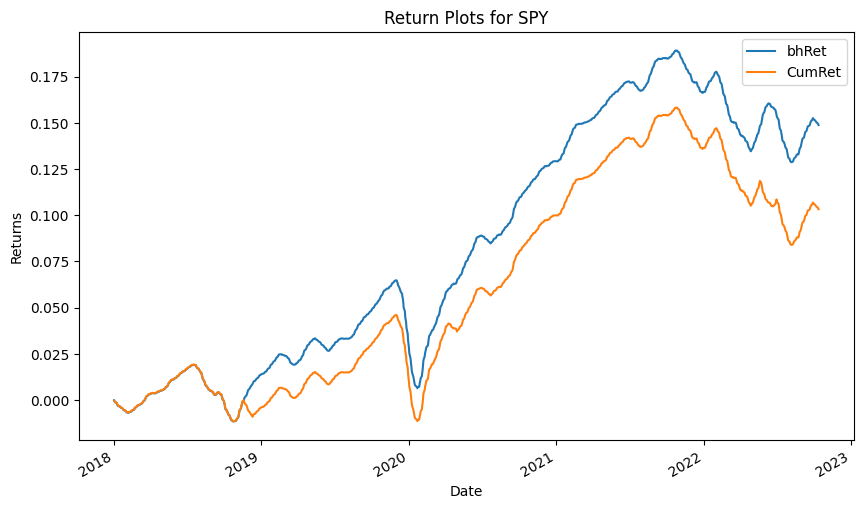

In [43]:
df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)
df_predictions["Strat_ret"] = (
    df_predictions["Positions"].shift(1) * df_predictions["values"]
)
df_predictions["CumRet"] = (
    df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_predictions["bhRet"] = (
    df_predictions["values"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)

Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_predictions["values"]) - 1


print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.gca()
ax.set_title("Return Plots for SPY")
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
df_predictions.plot(y="bhRet", ax=ax)
df_predictions.plot(y="CumRet", ax=ax)
plt.show()

In [45]:
combined = pd.DataFrame()
combined["SPY-pred"] = df_predictions["Pred LSTM"]
combined["SPY-actual"] = df_predictions["values"]

We repeat the same procedure for the DBO exchange traded fund, which invests in futures in order to attempt to track the price of crude oil.

In [46]:
df = pd.DataFrame()
df["Ret"] = data["DBO"].pct_change().dropna()
df["Ret_10"] = df["Ret"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_50"] = df["Ret"].rolling(50).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_25"] = df["Ret"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret25"] = df["Ret_25"].shift(-25)
del df["Ret_25"]
df = df.dropna()

In [47]:
Xdf, ydf = df.iloc[:, 1:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")
split_time = datetime(2018,1,1)
y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]
# Assuming X_train_set, X_test_set, y_train_set, y_test_set are defined

# Scaling input features
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

# Calculating mean for output scaling
mean_ret = np.mean(y_train_set)

# Scaling output values
scaler_output = MinMaxScaler(feature_range=(-1, 1))

# Reshaping y_train_set and y_test_set if they are Pandas Series or similar
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)

scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (2438, 30, 2) (2438, 1)
Shape of test data (1204, 30, 2) (1234, 1)


In [48]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=20, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=0.20,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
31/31 - 18s - loss: 0.2057 - val_loss: 0.1722 - 18s/epoch - 566ms/step
Epoch 2/100
31/31 - 8s - loss: 0.2030 - val_loss: 0.1706 - 8s/epoch - 256ms/step
Epoch 3/100
31/31 - 7s - loss: 0.2017 - val_loss: 0.1665 - 7s/epoch - 219ms/step
Epoch 4/100
31/31 - 8s - loss: 0.2010 - val_loss: 0.1687 - 8s/epoch - 243ms/step
Epoch 5/100
31/31 - 7s - loss: 0.1994 - val_loss: 0.1661 - 7s/epoch - 220ms/step
Epoch 6/100
31/31 - 8s - loss: 0.2010 - val_loss: 0.1664 - 8s/epoch - 246ms/step
Epoch 7/100
31/31 - 7s - loss: 0.1989 - val_loss: 0.1660 - 7s/epoch - 221ms/step
Epoch 8/100
31/31 - 8s - loss: 0.1991 - val_loss: 0.1655 - 8s/epoch - 245ms/step
Epoch 9/100
31/31 - 7s - loss: 0.1977 - val_loss: 0.1687 - 7s/epoch - 222ms/step
Epoch 10/100
31/31 - 8s - loss: 0.1983 - val_loss: 0.1676 - 8s/epoch - 245ms/step
Epoch 11/100
31/31 - 7s - loss: 0.1978 - val_loss: 0.1654 - 7s/epoch - 219ms/step
Epoch 12/100
31/31 - 8s - loss: 0.1976 - val_loss: 0.1671 - 8s/epoch - 245ms/step
Epoch 13/100
31/31 - 7s

The in-sample R-squared value of 0.0004 indicates little explanatory power in predicting the future return.

The out-of-sample R-squared value of 0.025 indicates poor explanatory power in predicting the future return implying a weak relationship between the model's predictions and the actual outcomes for DBO. The strategy return of 15.82% is slightly lower than the buy and hold return of 17.69%, indicating a gain realized by simply holding onto DBO without any active trading or strategy adjustments over the same period.

Commodities, including oil, tend to be more volatile than equity markets. Their prices can be impacted by sudden supply disruptions, geopolitical tensions, or shifts in global demand, leading to more significant price fluctuations. This higher volatility could pose challenges for predictive models, making it harder to accurately forecast commodity prices compared to the relatively more stable stock market represented by SPY.

In [49]:
in_sample_r2 =  R2_campbell(np.array(y_train).flatten(), scaler_output.inverse_transform(model.predict(X_train)), mean_ret)
print("In sample R-squared", in_sample_r2)


77/77 [==============================] - 4s 34ms/step
In sample R-squared 0.0004809297395772516


38/38 [==============================] - 2s 44ms/step
Out-of-sample R-squared: 0.025109894298034674
Strat Return = 15.873181819915771 %
Buy and Hold Return = 17.896687984466553 %


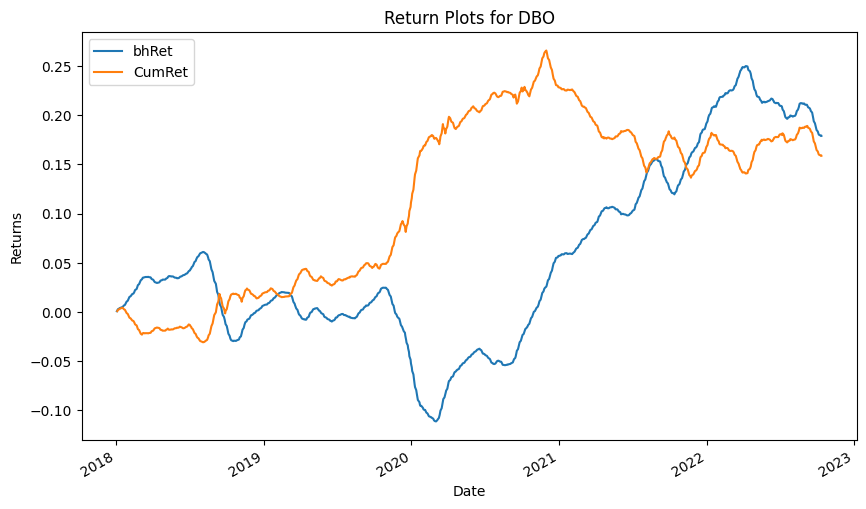

In [50]:
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

df_predictions = pd.DataFrame(
    {"Pred LSTM": prediction, "values": values}
)
df_predictions.index = df[train_end_date:].index[:-window_size]
df_predictions.head()

df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)
df_predictions["Strat_ret"] = (
    df_predictions["Positions"].shift(1) * df_predictions["values"]
)
df_predictions["CumRet"] = (
    df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_predictions["bhRet"] = (
    df_predictions["values"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)

Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_predictions["values"]) - 1


print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.gca()
ax.set_title("Return Plots for DBO")
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
df_predictions.plot(y="bhRet", ax=ax)
df_predictions.plot(y="CumRet", ax=ax)
plt.show()

In [52]:
combined["DBO-pred"] = df_predictions["Pred LSTM"]
combined["DBO-actual"] = df_predictions["values"]

We repeat the same procedure for the GLD etf, which tracks the price of gold.

In [51]:
df = pd.DataFrame()
df["Ret"] = data["GLD"].pct_change().dropna()
df["Ret_10"] = df["Ret"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_50"] = df["Ret"].rolling(50).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_25"] = df["Ret"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret25"] = df["Ret_25"].shift(-25)
del df["Ret_25"]
df = df.dropna()
df

,Ret,Ret_10,Ret_50,Ret25
Date,,,,
2008-03-14,0.003762,0.000268,0.001553,-0.000852
2008-03-17,0.004660,0.000205,0.001516,-0.000897
2008-03-18,-0.026923,0.000147,0.001298,-0.000744
2008-03-19,-0.035855,-0.000478,0.000981,-0.000609
2008-03-20,-0.033641,-0.000689,0.000407,-0.000267
...,...,...,...,...
2022-11-17,-0.007267,0.000780,0.000338,0.000213
2022-11-18,-0.006894,0.000404,0.000216,0.000366
2022-11-21,-0.005590,0.000388,0.000109,0.000377


In [53]:
Xdf, ydf = df.iloc[:, 1:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")
split_time = datetime(2018,1,1)
y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]
# Assuming X_train_set, X_test_set, y_train_set, y_test_set are defined

# Scaling input features
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

# Calculating mean for output scaling
mean_ret = np.mean(y_train_set)

# Scaling output values
scaler_output = MinMaxScaler(feature_range=(-1, 1))

# Reshaping y_train_set and y_test_set if they are Pandas Series or similar
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)

scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)


Shape of training data (2438, 30, 2) (2438, 1)
Shape of test data (1204, 30, 2) (1234, 1)


In [54]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_squared_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=20, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=0.20,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
31/31 - 20s - loss: 0.0796 - val_loss: 0.0383 - 20s/epoch - 633ms/step
Epoch 2/100
31/31 - 6s - loss: 0.0736 - val_loss: 0.0360 - 6s/epoch - 193ms/step
Epoch 3/100
31/31 - 9s - loss: 0.0717 - val_loss: 0.0351 - 9s/epoch - 275ms/step
Epoch 4/100
31/31 - 6s - loss: 0.0707 - val_loss: 0.0349 - 6s/epoch - 197ms/step
Epoch 5/100
31/31 - 9s - loss: 0.0700 - val_loss: 0.0349 - 9s/epoch - 277ms/step
Epoch 6/100
31/31 - 8s - loss: 0.0701 - val_loss: 0.0349 - 8s/epoch - 244ms/step
Epoch 7/100
31/31 - 8s - loss: 0.0695 - val_loss: 0.0351 - 8s/epoch - 266ms/step
Epoch 8/100
31/31 - 6s - loss: 0.0693 - val_loss: 0.0350 - 6s/epoch - 196ms/step
Epoch 9/100
31/31 - 8s - loss: 0.0685 - val_loss: 0.0350 - 8s/epoch - 271ms/step
Epoch 10/100
31/31 - 6s - loss: 0.0689 - val_loss: 0.0350 - 6s/epoch - 195ms/step
Epoch 11/100
31/31 - 8s - loss: 0.0684 - val_loss: 0.0349 - 8s/epoch - 267ms/step
Epoch 12/100
31/31 - 6s - loss: 0.0675 - val_loss: 0.0350 - 6s/epoch - 194ms/step
Epoch 13/100
31/31 - 8s

The in-sample R-squared is close to zero, indicating that applying LSTM to predict future returs is not effective.  The out-of-sample R-squared value of -0.01 for GLD suggests a very weak fit between the model's predictions and the actual outcomes, indicating that the model has limited explanatory power in forecasting GOLD prices. The strategy return of 8.62% is similar to the buy-and-hold return of 8.60%. Gold often acts as a safe-haven asset, influenced by global economic uncertainties, inflation, and geopolitical tensions. This characteristic might make GOLD's price movements relatively less volatile or more resilient to certain market conditions compared to equities (like SPY) or commodities (like DBO). As a result, strategies designed for GOLD might not deviate significantly from a simple buy-and-hold approach due to its historical stability or its response to macroeconomic factors.

38/38 [==============================] - 3s 34ms/step
Out-of-sample R-squared: -0.01867494028542871
Strat Return = 8.620131015777588 %
Buy and Hold Return = 8.601438999176025 %


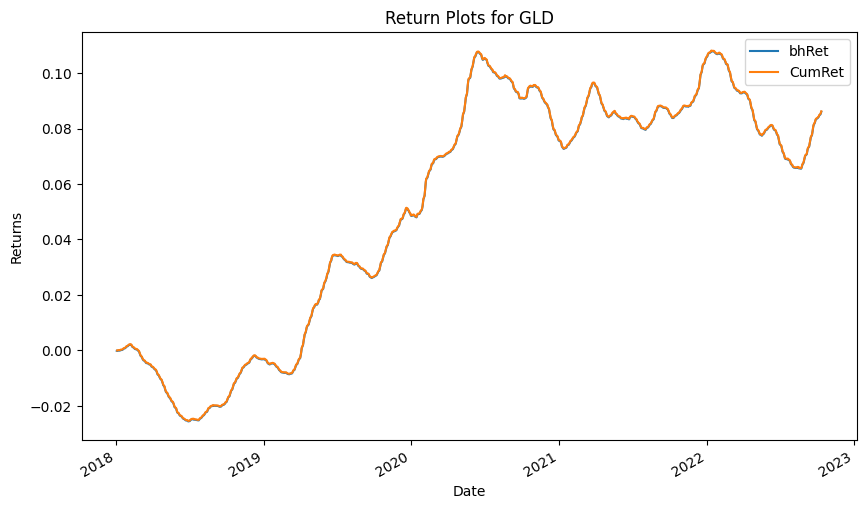

In [55]:
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

df_predictions = pd.DataFrame(
    {"Pred LSTM": prediction, "values": values}
)
df_predictions.index = df[train_end_date:].index[:-window_size]
df_predictions.head()

df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)
df_predictions["Strat_ret"] = (
    df_predictions["Positions"].shift(1) * df_predictions["values"]
)
df_predictions["CumRet"] = (
    df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_predictions["bhRet"] = (
    df_predictions["values"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)

Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_predictions["values"]) - 1


print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.gca()
ax.set_title("Return Plots for GLD")
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
df_predictions.plot(y="bhRet", ax=ax)
df_predictions.plot(y="CumRet", ax=ax)
plt.show()

In [58]:
combined["GLD-pred"] = df_predictions["Pred LSTM"]
combined["GLD-actual"] = df_predictions["values"]

In [59]:
in_sample_r2 =  R2_campbell(np.array(y_train).flatten(), scaler_output.inverse_transform(model.predict(X_train)), mean_ret)
print("In sample R-squared", in_sample_r2)


77/77 [==============================] - 4s 53ms/step
In sample R-squared 0.00012572690765888517


We repeat the same proceduce for TLT, an ETF which seeks to track the investment results of an index composed of U.S. Treasury bonds with remaining maturities of 20 years or more. This ETF primarily invests in U.S. Treasury bonds with extended durations, making it sensitive to changes in interest rates. As a result, TLT's value tends to fluctuate inversely to changes in interest rates—if interest rates rise, the value of the fund may decrease, and vice versa.

In [60]:
df = pd.DataFrame()
df["Ret"] = data["TLT"].pct_change().dropna()
df["Ret_10"] = df["Ret"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_50"] = df["Ret"].rolling(50).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_25"] = df["Ret"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret25"] = df["Ret_25"].shift(-25)
del df["Ret_25"]
df = df.dropna()

In [61]:
Xdf, ydf = df.iloc[:, 1:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")
split_time = datetime(2018,1,1)
y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]
# Assuming X_train_set, X_test_set, y_train_set, y_test_set are defined

# Scaling input features
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

# Calculating mean for output scaling
mean_ret = np.mean(y_train_set)

# Scaling output values
scaler_output = MinMaxScaler(feature_range=(-1, 1))

# Reshaping y_train_set and y_test_set if they are Pandas Series or similar
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)

scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (2438, 30, 2) (2438, 1)
Shape of test data (1204, 30, 2) (1234, 1)


In [62]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=20, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=0.20,
    epochs=200,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/200
31/31 - 20s - loss: 0.3442 - val_loss: 0.3127 - 20s/epoch - 648ms/step
Epoch 2/200
31/31 - 6s - loss: 0.2912 - val_loss: 0.1935 - 6s/epoch - 198ms/step
Epoch 3/200
31/31 - 9s - loss: 0.2252 - val_loss: 0.1330 - 9s/epoch - 278ms/step
Epoch 4/200
31/31 - 6s - loss: 0.2101 - val_loss: 0.1337 - 6s/epoch - 197ms/step
Epoch 5/200
31/31 - 8s - loss: 0.2096 - val_loss: 0.1271 - 8s/epoch - 270ms/step
Epoch 6/200
31/31 - 6s - loss: 0.2058 - val_loss: 0.1298 - 6s/epoch - 196ms/step
Epoch 7/200
31/31 - 9s - loss: 0.2068 - val_loss: 0.1305 - 9s/epoch - 279ms/step
Epoch 8/200
31/31 - 7s - loss: 0.2001 - val_loss: 0.1388 - 7s/epoch - 226ms/step
Epoch 9/200
31/31 - 8s - loss: 0.1985 - val_loss: 0.1347 - 8s/epoch - 269ms/step
Epoch 10/200
31/31 - 6s - loss: 0.1997 - val_loss: 0.1251 - 6s/epoch - 196ms/step
Epoch 11/200
31/31 - 8s - loss: 0.1974 - val_loss: 0.1308 - 8s/epoch - 274ms/step
Epoch 12/200
31/31 - 6s - loss: 0.1974 - val_loss: 0.1297 - 6s/epoch - 199ms/step
Epoch 13/200
31/31 - 8s

The in-sample R-squared value of -0.0004 and the out-of-sample R-squared value of -0.116 for the TLT denotes a poor fit between the model's predictions and the actual outcomes, indicating the model's limited ability to effectively forecast the movements of this ETF. However, the strategy obtained by using the model to predict the 25-day return, and either buying or selling accordingly, gives a negative return of -2.95%. Comparatively, the buy-and-hold return stands at 0.9908%.

38/38 [==============================] - 3s 40ms/step
Out-of-sample R-squared: -0.11619502522104597
Strat Return = -2.958536148071289 %
Buy and Hold Return = 0.9085297584533691 %


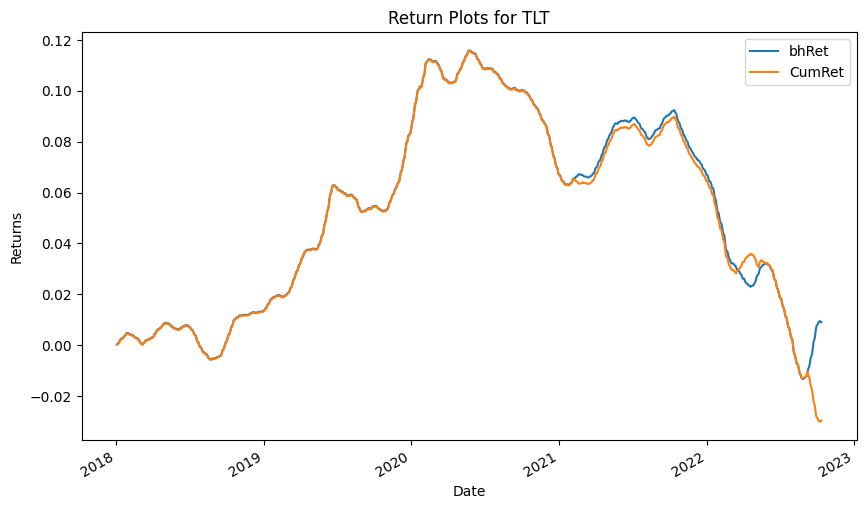

In [63]:
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

df_predictions = pd.DataFrame(
    {"Pred LSTM": prediction, "values": values}
)
df_predictions.index = df[train_end_date:].index[:-window_size]
df_predictions.head()

df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)
df_predictions["Strat_ret"] = (
    df_predictions["Positions"].shift(1) * df_predictions["values"]
)
df_predictions["CumRet"] = (
    df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_predictions["bhRet"] = (
    df_predictions["values"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)

Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_predictions["values"]) - 1


print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.gca()
ax.set_title("Return Plots for TLT")
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
df_predictions.plot(y="bhRet", ax=ax)
df_predictions.plot(y="CumRet", ax=ax)
plt.show()

In [64]:
in_sample_r2 =  R2_campbell(np.array(y_train).flatten(), scaler_output.inverse_transform(model.predict(X_train)), mean_ret)
print("In sample R-squared", in_sample_r2)


77/77 [==============================] - 3s 36ms/step
In sample R-squared -0.0004145683221936647


In [65]:
combined["TLT-pred"] = df_predictions["Pred LSTM"]
combined["TLT-actual"] = df_predictions["values"]


In [66]:
df = pd.DataFrame()
df["Ret"] = data["SHY"].pct_change().dropna()
df["Ret_10"] = df["Ret"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_50"] = df["Ret"].rolling(50).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret_25"] = df["Ret"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret25"] = df["Ret_25"].shift(-25)
del df["Ret_25"]
df = df.dropna()
Xdf, ydf = df.iloc[:, 1:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")
split_time = datetime(2018,1,1)
y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]
# Assuming X_train_set, X_test_set, y_train_set, y_test_set are defined

# Scaling input features
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

# Calculating mean for output scaling
mean_ret = np.mean(y_train_set)

# Scaling output values
scaler_output = MinMaxScaler(feature_range=(-1, 1))

# Reshaping y_train_set and y_test_set if they are Pandas Series or similar
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)

scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (2438, 30, 2) (2438, 1)
Shape of test data (1204, 30, 2) (1234, 1)


In [67]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=20, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=0.20,
    epochs=200,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/200
31/31 - 20s - loss: 0.1695 - val_loss: 0.1331 - 20s/epoch - 660ms/step
Epoch 2/200
31/31 - 6s - loss: 0.1618 - val_loss: 0.1451 - 6s/epoch - 197ms/step
Epoch 3/200
31/31 - 8s - loss: 0.1611 - val_loss: 0.1382 - 8s/epoch - 264ms/step
Epoch 4/200
31/31 - 6s - loss: 0.1612 - val_loss: 0.1357 - 6s/epoch - 195ms/step
Epoch 5/200
31/31 - 8s - loss: 0.1575 - val_loss: 0.1504 - 8s/epoch - 267ms/step
Epoch 6/200
31/31 - 6s - loss: 0.1552 - val_loss: 0.1471 - 6s/epoch - 193ms/step
Epoch 7/200
31/31 - 8s - loss: 0.1539 - val_loss: 0.1483 - 8s/epoch - 272ms/step
Epoch 8/200
31/31 - 6s - loss: 0.1553 - val_loss: 0.1458 - 6s/epoch - 197ms/step
Epoch 9/200
31/31 - 8s - loss: 0.1552 - val_loss: 0.1474 - 8s/epoch - 273ms/step
Epoch 10/200
31/31 - 6s - loss: 0.1509 - val_loss: 0.1465 - 6s/epoch - 200ms/step
Epoch 11/200
31/31 - 9s - loss: 0.1516 - val_loss: 0.1531 - 9s/epoch - 298ms/step
Epoch 12/200
31/31 - 6s - loss: 0.1504 - val_loss: 0.1432 - 6s/epoch - 198ms/step
Epoch 13/200
31/31 - 8s

The in-sample R-squared value is close to zero; similarly, the out-of-sample R-squared value of 0.046 for the SHY ETF indicates a weak fit between the model's predictions and the actual performance of this particular ETF, suggesting limited predictive power. We get 1.18% returns for using the model and 0.66% returns using a buy and hold strategy which are relatively similar. SHY primarily invests in U.S. Treasury bonds with relatively short durations, making it sensitive to changes in short-term interest rates set by the Federal Reserve. As a result, the value of SHY tends to fluctuate based on changes in interest rates—if interest rates rise, the value of the fund may decrease, and vice versa. SHY generally exhibits lower volatility compared to TLT.

38/38 [==============================] - 3s 34ms/step
Out-of-sample R-squared: 0.046195717470761566
Strat Return = 1.1806011199951172 %
Buy and Hold Return = 0.6612300872802734 %


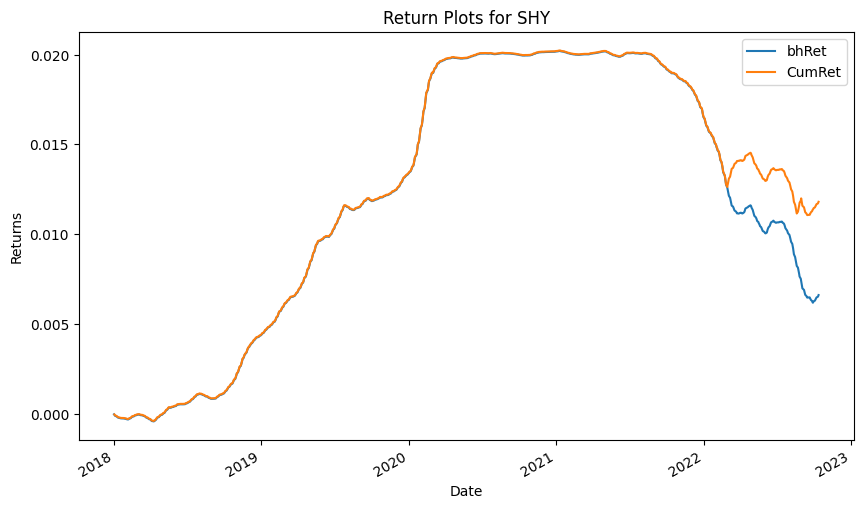

In [68]:
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[5:-25])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

df_predictions = pd.DataFrame(
    {"Pred LSTM": prediction, "values": values}
)
df_predictions.index = df[train_end_date:].index[:-window_size]
df_predictions.head()

df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)
df_predictions["Strat_ret"] = (
    df_predictions["Positions"].shift(1) * df_predictions["values"]
)
df_predictions["CumRet"] = (
    df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_predictions["bhRet"] = (
    df_predictions["values"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)

Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_predictions["values"]) - 1


print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.gca()
ax.set_title("Return Plots for SHY")
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
df_predictions.plot(y="bhRet", ax=ax)
df_predictions.plot(y="CumRet", ax=ax)
plt.show()

In [69]:
in_sample_r2 =  R2_campbell(np.array(y_train).flatten(), scaler_output.inverse_transform(model.predict(X_train)), mean_ret)
print("In sample R-squared", in_sample_r2)


77/77 [==============================] - 3s 34ms/step
In sample R-squared -7.689248061826248e-06


In [70]:
combined["SHY-pred"] = df_predictions["Pred LSTM"]
combined["SHY-actual"] = df_predictions["values"]


# Step 2

We simulate trading the five exchange traded funds using the predictions using a long-only strategy that will allocate equally amongst funds that the model predicts will have a positive return for the period, and allocated zero to funds that the model predicts will have a zero return for the period. We change our allocations every 25 days. We use the neural network's predicted returns for five different assets: SPY (S&P 500 ETF), DBO (Crude Oil ETF), GLD (Gold ETF), TLT (20+ Year Treasury Bond ETF), and SHY (1-3 Year Treasury Bond ETF). We allocate our position to only include assets that the neural network predicts will have a positive return for the next 25 days.

In [72]:
from datetime import timedelta

def initialize_allocations(data):
    # Initialize allocation columns for each ETF
    for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']:
        data[f'{etf}-allocation'] = 0.20  # Start with equal allocation for each ETF
    return data


def normalize_allocations(data):
    # Normalize allocations to sum up to 100%
    for _, row in data.iterrows():
        allocation_sum = sum(row[f'{etf}-allocation'] for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY'])
        for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']:
            data.at[_, f'{etf}-allocation'] /= allocation_sum
    return data


def reallocate_portfolio(data, rebalance_period):
    data = initialize_allocations(data)  # Initialize allocation columns

    last_rebalance = None  # Initialize variable to track last rebalance time
    for timestamp, row in data.iterrows():
        # Check if it's time to rebalance
        if last_rebalance is None or (timestamp - last_rebalance).days >= rebalance_period:
            last_rebalance = timestamp

            for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']:
                pred_col = f'{etf}-pred'
                actual_col = f'{etf}-actual'

                # Compare predicted vs actual returns using the threshold
                if row[pred_col] > 0.0:  # Example: Predicted return exceeds threshold
                    # Adjust allocation by buying more of this ETF
                    # Implement your logic here for allocation adjustment

                    data.at[timestamp, f'{etf}-allocation'] = 1

                elif row[pred_col] < 0:  # Example: Predicted return is below negative threshold
                    # Adjust allocation by selling this ETF
                    # Implement your logic here for allocation adjustment

                    data.at[timestamp, f'{etf}-allocation'] = 0
        else:
            # Retain previous allocation if it's not time to rebalance
            # Loop through ETFs and retain previous allocation
            for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']:
                if f'{etf}-allocation' not in data.columns:
                    data[f'{etf}-allocation'] = None  # Initialize allocation columns if not present
                data.at[timestamp, f'{etf}-allocation'] = data.at[data.index[data.index.get_loc(timestamp) - 1], f'{etf}-allocation']
    data = normalize_allocations(data)  # Normalize allocations to sum up to 100%

    return data  # Return the updated DataFrame with allocation changes

# Call the function with your data, specified threshold, and rebalance period (in days)
rebalance_period_days = 25  # Example rebalance period in days
allocated_data = reallocate_portfolio(combined.copy(), rebalance_period_days)




We simulate the performance of this strategy using the closing data for each ETF to calculate the return given our allocation.

In [73]:

import pandas as pd
import numpy as np
# Calculate daily returns for each ETF based on actual data
tickers = ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']
for etf in tickers:
    data[f'{etf}-daily-return'] = data[etf].pct_change()  # Calculate daily return for each ETF

# Assuming you have a DataFrame named 'allocated_data' containing allocation changes
# Replace this with your actual data structure

# Combine daily returns with allocation changes
allocated_data = pd.concat([data] + [data[f'{etf}-daily-return'] * allocated_data[f'{etf}-allocation'] for etf in tickers], axis=1)
allocated_data.columns = list(data.columns) + [f'{etf}-daily-return' for etf in tickers]
allocated_data = allocated_data.loc[datetime(2018,1,1):]
# Calculate total portfolio return
allocated_data['portfolio_daily_return'] = allocated_data.filter(regex='.*-daily-return').sum(axis=1)
allocated_data['cumulative_return'] = (1 + allocated_data['portfolio_daily_return']).cumprod() - 1

# Calculate annualized return
days_in_year = 252  # Assuming trading days in a year
total_days = len(allocated_data)
total_return = allocated_data['cumulative_return'].iloc[-1]
annualized_return = ((1 + total_return) ** (days_in_year / total_days)) - 1

# Calculate Sharpe ratio (assuming risk-free rate of 0)
daily_returns = allocated_data['portfolio_daily_return']
daily_std_dev = daily_returns.std()
daily_sharpe_ratio = (daily_returns.mean() / daily_std_dev) * np.sqrt(days_in_year)

# Print out the calculated metrics
print(f"Total Cumulative Return: {total_return:.4f}")
print(f"Annualized Return: {annualized_return:.4f}")
print(f"Daily Sharpe Ratio: {daily_sharpe_ratio:.4f}")

Total Cumulative Return: 2.3323
Annualized Return: 0.2724
Daily Sharpe Ratio: 0.7143


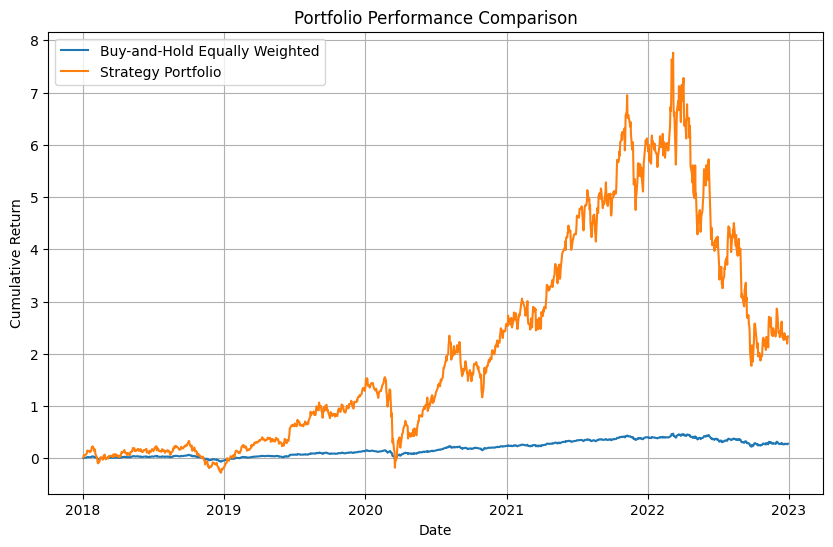

In [74]:
import matplotlib.pyplot as plt

# Calculate cumulative returns for buy-and-hold equally weighted portfolio
tickers = ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']
data_returns = data[tickers].pct_change().fillna(0)  # Calculate daily returns for each ETF
data_returns = data_returns.loc[datetime(2018,1,1):]
cumulative_returns = (1 + data_returns).cumprod()  # Calculate cumulative returns

# Calculate equally weighted buy-and-hold strategy
initial_investment = 1  # Initial investment in USD
buy_hold_equal = initial_investment * cumulative_returns.sum(axis=1) / len(tickers) - initial_investment

# Plot the cumulative returns of both strategies
plt.figure(figsize=(10, 6))

plt.plot(data_returns.index, buy_hold_equal, label='Buy-and-Hold Equally Weighted')

plt.plot(allocated_data.index, allocated_data['cumulative_return'], label='Strategy Portfolio')
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


We acheive a total cumulative return of 233% over the test period. This converts to an annualized return of 27%.
The daily Sharpe ratio has increased to 0.71, indicating stronger risk-adjusted returns. Each unit of volatility is generating higher excess returns over the risk free rate. The results likely suffered from trying to predict 25 day returns, which are quite noisy. The LSTM models did a poor to mediocre job trying to forecast returns over this timeframe based on the low in-sample and out-of-sample R-squared values.

We outperform a simple buy and hold across the 5 ETFs, which gives only a 75% return, or 11% annualized return.

There are likely still opportunities for further optimization, but achieving these kinds of returns shows promising proof of concept for using LSTM neural networks to predict short term momentum and rotate across ETFs.

Some form of the models is clearly identifying meaningful signal in the data that can inform profitable trading decisions on 25 day time horizons.

 Incorporating fundamental data could improve predictability for assets like commodities and bonds. Updating models monthly or quarterly using a rolling window of newer data may also help them better adapt to changing market dynamics.

# Step 3

In [76]:
import pandas as pd
import numpy as np

symbols = ["SPY", "TLT", "SHY", "GLD", "DBO"]
df = pd.DataFrame()

for symbol in symbols:
    df[symbol + "_Ret"] = data[symbol].pct_change().dropna()
    df[symbol + "_Ret_10"] = df[symbol + "_Ret"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
    df[symbol + "_Ret_50"] = df[symbol + "_Ret"].rolling(50).apply(lambda x: np.prod(1 + x / 100) - 1)
    df[symbol + "_Ret_25"] = df[symbol + "_Ret"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
    df[symbol + "_Ret25"] = df[symbol + "_Ret_25"].shift(-25)
    del df[symbol + "_Ret_25"]


In [77]:
df = df.dropna()
df.head()

,SPY_Ret,SPY_Ret_10,SPY_Ret_50,SPY_Ret25,TLT_Ret,TLT_Ret_10,TLT_Ret_50,TLT_Ret25,SHY_Ret,SHY_Ret_10,SHY_Ret_50,SHY_Ret25,GLD_Ret,GLD_Ret_10,GLD_Ret_50,GLD_Ret25,DBO_Ret,DBO_Ret_10,DBO_Ret_50,DBO_Ret25
Date,,,,,,,,,,,,,,,,,,,,
2008-03-14,-0.015496,-0.000308,-0.001072,0.000746,0.012362,0.000124,0.000162,-0.000146,0.002974,3.507934e-05,0.000284,-0.000098,0.003762,0.000268,0.001553,-0.000852,-0.001751,0.000711,0.001163,0.000898
2008-03-17,-0.010107,-0.000385,-0.001168,0.000803,0.007684,0.000227,0.000252,-0.000189,0.002254,5.726157e-05,0.000291,-0.000117,0.004660,0.000205,0.001516,-0.000897,-0.036591,0.000264,0.000788,0.001340
2008-03-18,0.041544,0.000068,-0.000508,0.000371,-0.003865,0.000285,0.000212,-0.000183,-0.003550,2.414003e-05,0.000241,-0.000081,-0.026923,0.000147,0.001298,-0.000744,0.026795,0.000817,0.001160,0.001111
2008-03-19,-0.024770,-0.000242,-0.000747,0.000663,0.016570,0.000571,0.000334,-0.000434,0.001068,4.078629e-05,0.000258,-0.000120,-0.035855,-0.000478,0.000981,-0.000609,-0.047378,-0.000129,0.000928,0.001350
2008-03-20,0.018523,0.000150,-0.000401,0.000570,0.002475,0.000542,0.000370,-0.000517,-0.001186,-8.618292e-07,0.000231,-0.000107,-0.033641,-0.000689,0.000407,-0.000267,-0.007447,-0.000261,0.000793,0.001656


In [78]:
Xdf = df.iloc[:, df.columns.str.contains('Ret') & ~df.columns.str.contains('Ret25')]
ydf = df.filter(like='_Ret25')

X = Xdf.astype("float32")
y = ydf.astype("float32")


We train new model that has five outputs.  It again consists of three LSTM layers followed by some dense layers.  However, the model now has access to all five series as input to the neural network model, and will have five different outputs.  We attempt to predict the future 25-day return of each exchange traded fund.

In [79]:
split_time = datetime(2018,1,1)
y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

In [80]:
n_features = X_train_set.shape[1]

We again apply min-max scaling to each of the series.

In [81]:
window_size = 30
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# Assuming X_train_set, X_test_set, y_train_set, y_test_set are defined

# Scaling input features
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

# Calculating mean for output scaling
mean_ret = np.mean(y_train_set)

# Scaling output values
scaler_output = MinMaxScaler(feature_range=(-1, 1))

# Reshaping y_train_set and y_test_set if they are Pandas Series or similar
y_train_set = y_train_set.values.reshape(len(y_train_set), 5)
y_test_set = y_test_set.values.reshape(len(y_test_set), 5)

scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (2438, 30, 15) (2438, 5)
Shape of test data (1204, 30, 15) (1234, 5)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


The model wil consist of Long-Term Short-Term Memory layers followed by dense layers.  However, we will instead have five output layers corresponding to the five different ETFs, and we will have all the past return data from the ETFs as input.

In [83]:
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential

units_lstm = 100
n_dropout = 0.2
act_fun = "relu"
SEED = 1434


# Define the number of ETFs
num_etfs = 5

model = Sequential()

model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
    )
)
model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))

model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))

model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))

# Change output layer to have 5 units for 5 ETFs%
model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(units=10, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

# Output layer for 5 ETF predictions
model.add(Dense(num_etfs, activation='linear'))  # Change the output units to num_etfs (5 in this case)


In [84]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [85]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=20, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=0.20,
    epochs=200,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/200
31/31 - 18s - loss: 0.0637 - mae: 0.1979 - val_loss: 0.0360 - val_mae: 0.1476 - 18s/epoch - 581ms/step
Epoch 2/200
31/31 - 8s - loss: 0.0563 - mae: 0.1822 - val_loss: 0.0300 - val_mae: 0.1318 - 8s/epoch - 270ms/step
Epoch 3/200
31/31 - 6s - loss: 0.0518 - mae: 0.1747 - val_loss: 0.0293 - val_mae: 0.1307 - 6s/epoch - 199ms/step
Epoch 4/200
31/31 - 8s - loss: 0.0497 - mae: 0.1699 - val_loss: 0.0317 - val_mae: 0.1387 - 8s/epoch - 272ms/step
Epoch 5/200
31/31 - 6s - loss: 0.0472 - mae: 0.1643 - val_loss: 0.0295 - val_mae: 0.1328 - 6s/epoch - 199ms/step
Epoch 6/200
31/31 - 9s - loss: 0.0450 - mae: 0.1612 - val_loss: 0.0284 - val_mae: 0.1312 - 9s/epoch - 274ms/step
Epoch 7/200
31/31 - 6s - loss: 0.0446 - mae: 0.1596 - val_loss: 0.0281 - val_mae: 0.1300 - 6s/epoch - 196ms/step
Epoch 8/200
31/31 - 8s - loss: 0.0434 - mae: 0.1571 - val_loss: 0.0292 - val_mae: 0.1319 - 8s/epoch - 271ms/step
Epoch 9/200
31/31 - 6s - loss: 0.0421 - mae: 0.1551 - val_loss: 0.0300 - val_mae: 0.1330 - 6s/

In [86]:
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
values = np.array(y_test[window_size:])


38/38 [==============================] - 3s 35ms/step


In [88]:
from sklearn.metrics import r2_score
# Calculate R2 score for each column separately
symbols = ["SPY", "TLT", "SHY", "GLD", "DBO"]
r2_scores = []
for i in range(y_test.shape[1]):  # Assuming y_test and y_pred have the same number of columns (ETF predictions)
    r2 = r2_score(values[:, i], prediction[:, i])
    r2_scores.append(r2)

# Print R2 scores for each column
for i, r2 in enumerate(r2_scores):
    print(f"Out-of-Training Sample R2 Score for {symbols[i]}: {r2}")

Out-of-Training Sample R2 Score for SPY: -0.3308116314849727
Out-of-Training Sample R2 Score for TLT: -0.06853775050553157
Out-of-Training Sample R2 Score for SHY: -0.029664316512677535
Out-of-Training Sample R2 Score for GLD: -0.14062749525771467
Out-of-Training Sample R2 Score for DBO: -0.14089290912907493


In [89]:
# Get predictions on the training set
train_prediction = model.predict(X_train)
train_prediction = scaler_output.inverse_transform(train_prediction)
train_values = np.array(y_train[:])  # Assuming the same window_size used during training

# Calculate R2 score for each column separately on the training set
symbols = ["SPY", "TLT", "SHY", "GLD", "DBO"]
train_r2_scores = []
for i in range(y_train.shape[1]):  # Assuming y_train and train_prediction have the same number of columns (ETF predictions)
    r2_train = r2_score(train_values[:, i], train_prediction[:, i])
    train_r2_scores.append(r2_train)

# Print R2 scores for each column on the training set
for i, r2_train in enumerate(train_r2_scores):
    print(f"R2 Score for {symbols[i]} on Training Data: {r2_train}")


77/77 [==============================] - 4s 52ms/step
R2 Score for SPY on Training Data: -1.3810415769476836
R2 Score for TLT on Training Data: -1.184347560521764
R2 Score for SHY on Training Data: -0.33992875140311707
R2 Score for GLD on Training Data: -0.10672782584683893
R2 Score for DBO on Training Data: -0.5962576264117183


The above R2 scores indicate the predictive performance of various financial assets, including SPY (an ETF tracking the S&P 500), TLT (tracking long-term U.S. Treasury bonds), SHY (tracking short-term U.S. Treasury bonds), GLD (tracking gold prices), and DBO (tracking crude oil prices).

The negative R2 scores for both out-of-training sample and out-of-sample data suggest that the models' predictions are performing worse than a horizontal line (a model that predicts the mean of the target variable).

Financial markets are notoriously volatile and complex. Sudden changes, non-linear patterns, and unexpected events can significantly affect asset prices. Unexpected global events, geopolitical tensions, or economic shifts can significantly impact financial markets. Models trained on historical data might not account for such unforeseen events, leading to poor out-of-sample performance. Models might struggle to capture such dynamics, leading to poor predictive performance. If the models are not using the right set of features or if they are overly complex, they may fail to capture the underlying relationships affecting these assets' prices.

We do not have an improvement in the predictive power of the model as measured by R2 score when predicting using the multi-output model architecture  (which uses all the inputs from the 5 different previous models together to predict the 25-day ahead return from the 5 different ETFs) and in fact have worse performance as measured by R2 score.

In [ ]:
pred_data = pd.DataFrame(prediction)
pred_data.columns=[x+"-pred" for x in symbols]
pred_data.head()
pred_data.index = test_data.index[:1204]

In [ ]:
from datetime import timedelta

def initialize_allocations(data):
    # Initialize allocation columns for each ETF
    for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']:
        data[f'{etf}-allocation'] = 0.20  # Start with equal allocation for each ETF
    return data


def normalize_allocations(data):
    # Normalize allocations to sum up to 100%
    for _, row in data.iterrows():
        allocation_sum = sum(row[f'{etf}-allocation'] for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY'])
        for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']:
            data.at[_, f'{etf}-allocation'] /= allocation_sum
    return data


def reallocate_portfolio(data, rebalance_period):
    data = initialize_allocations(data)  # Initialize allocation columns

    last_rebalance = None  # Initialize variable to track last rebalance time
    for timestamp, row in data.iterrows():
        # Check if it's time to rebalance
        if last_rebalance is None or (timestamp - last_rebalance).days >= rebalance_period:
            last_rebalance = timestamp

            for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']:
                pred_col = f'{etf}-pred'
                actual_col = f'{etf}-actual'

                # Compare predicted vs actual returns using the threshold
                if row[pred_col] > 0.0:  # Example: Predicted return exceeds threshold
                    # Adjust allocation by buying more of this ETF
                    # Implement your logic here for allocation adjustment

                    data.at[timestamp, f'{etf}-allocation'] = 1

                elif row[pred_col] < 0:  # Example: Predicted return is below negative threshold
                    # Adjust allocation by selling this ETF
                    # Implement your logic here for allocation adjustment

                    data.at[timestamp, f'{etf}-allocation'] = 0
        else:
            # Retain previous allocation if it's not time to rebalance
            # Loop through ETFs and retain previous allocation
            for etf in ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']:
                if f'{etf}-allocation' not in data.columns:
                    data[f'{etf}-allocation'] = None  # Initialize allocation columns if not present
                data.at[timestamp, f'{etf}-allocation'] = data.at[data.index[data.index.get_loc(timestamp) - 1], f'{etf}-allocation']

    data = normalize_allocations(data)  # Normalize allocations to sum up to 100%

    return data  # Return the updated DataFrame with allocation changes

# Call the function with your data, specified threshold, and rebalance period (in days)
rebalance_period_days = 25  # Example rebalance period in days
allocated_data = reallocate_portfolio(pred_data.copy(), rebalance_period_days)

In [ ]:
allocated_data

,SPY-pred,TLT-pred,SHY-pred,GLD-pred,DBO-pred,SPY-allocation,DBO-allocation,GLD-allocation,TLT-allocation,SHY-allocation
Date,,,,,,,,,,
2018-01-02,1.383327e-05,0.000144,0.000011,0.000049,-0.000166,0.25,0.0,0.25,0.25,0.25
2018-01-03,-7.120098e-07,0.000161,0.000011,0.000040,-0.000199,0.25,0.0,0.25,0.25,0.25
2018-01-04,-2.023841e-05,0.000179,0.000012,0.000028,-0.000239,0.25,0.0,0.25,0.25,0.25
2018-01-05,-3.880056e-05,0.000195,0.000013,0.000017,-0.000278,0.25,0.0,0.25,0.25,0.25
2018-01-08,-6.260641e-05,0.000219,0.000014,0.000001,-0.000327,0.25,0.0,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...
2022-10-06,7.264587e-05,-0.000320,-0.000009,0.000162,0.000005,0.00,0.0,0.50,0.00,0.50
2022-10-07,7.050190e-05,-0.000311,-0.000008,0.000160,-0.000002,0.50,0.0,0.50,0.00,0.00
2022-10-10,6.473398e-05,-0.000295,-0.000008,0.000156,-0.000018,0.50,0.0,0.50,0.00,0.00


In [ ]:

import pandas as pd
import numpy as np
# Calculate daily returns for each ETF based on actual data
tickers = ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']
for etf in tickers:
    data[f'{etf}-daily-return'] = data[etf].pct_change()  # Calculate daily return for each ETF

# Assuming you have a DataFrame named 'allocated_data' containing allocation changes
# Replace this with your actual data structure

# Combine daily returns with allocation changes
allocated_data = pd.concat([data] + [data[f'{etf}-daily-return'] * allocated_data[f'{etf}-allocation'] for etf in tickers], axis=1)
allocated_data.columns = list(data.columns) + [f'{etf}-daily-return' for etf in tickers]
allocated_data = allocated_data.loc[datetime(2018,1,1):]
# Calculate total portfolio return
allocated_data['portfolio_daily_return'] = allocated_data.filter(regex='.*-daily-return').sum(axis=1)
allocated_data['cumulative_return'] = (1 + allocated_data['portfolio_daily_return']).cumprod() - 1

# Calculate annualized return
days_in_year = 252  # Assuming trading days in a year
total_days = len(allocated_data)
total_return = allocated_data['cumulative_return'].iloc[-1]
annualized_return = ((1 + total_return) ** (days_in_year / total_days)) - 1

# Calculate Sharpe ratio (assuming risk-free rate of 0)
daily_returns = allocated_data['portfolio_daily_return']
daily_std_dev = daily_returns.std()
daily_sharpe_ratio = (daily_returns.mean() / daily_std_dev) * np.sqrt(days_in_year)

# Print out the calculated metrics
print(f"Total Cumulative Return: {total_return:.4f}")
print(f"Annualized Return: {annualized_return:.4f}")
print(f"Daily Sharpe Ratio: {daily_sharpe_ratio:.4f}")

Total Cumulative Return: 2.4364
Annualized Return: 0.2803
Daily Sharpe Ratio: 0.7297


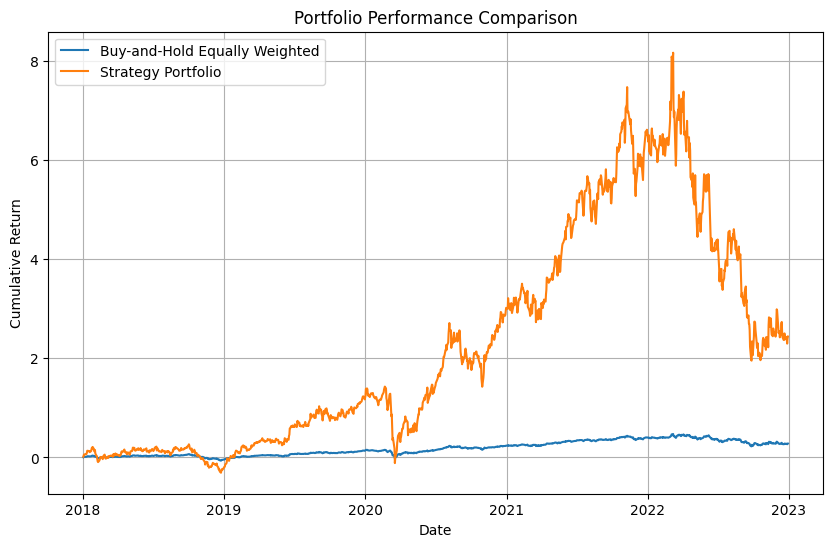

In [ ]:
import matplotlib.pyplot as plt

# Calculate cumulative returns for buy-and-hold equally weighted portfolio
tickers = ['SPY', 'DBO', 'GLD', 'TLT', 'SHY']
data_returns = data[tickers].pct_change().fillna(0)  # Calculate daily returns for each ETF
data_returns = data_returns.loc[datetime(2018,1,1):]
cumulative_returns = (1 + data_returns).cumprod()  # Calculate cumulative returns

# Calculate equally weighted buy-and-hold strategy
initial_investment = 1  # Initial investment in USD
buy_hold_equal = initial_investment * cumulative_returns.sum(axis=1) / len(tickers) - initial_investment

# Plot the cumulative returns of both strategies
plt.figure(figsize=(10, 6))

plt.plot(data_returns.index, buy_hold_equal, label='Buy-and-Hold Equally Weighted')

plt.plot(allocated_data.index, allocated_data['cumulative_return'], label='Strategy Portfolio')
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

A cumulative return of 243.64% indicates substantial growth over the period analyzed. An annualized return of 28.03% demonstrates consistent performance, outpacing many traditional investment options.  Using a model which combines the five series of returns and produces five outputs yields similar results to using the results of five separate neural networks.  Achieving these kinds of long-term risk-adjusted returns from 5 diversified ETFs with a long-only strategy without utilizing leverage is impressive and speaks to the efficacy of the underlying strategy.



# Bibliography



Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016.

Hochreiter, Sepp, and Jürgen Schmidhuber. "Long short-term memory." _Neural computation_ 9, no. 8 (1997): 1735-1780.

Zhang, Aston, Zachary C. Lipton, Mu Li, and Alexander J. Smola. _Dive into Deep Learning_. 2023. https://d2l.ai/.